In [60]:
from mip import *
import datetime
import pandas as pd
import numpy as np

In [61]:
# add length check with res & horizon
PARAM['Horizon'] = 4        # horizon to optimize (day)
PARAM['Resolution'] = 15    # sampling period(min)
PARAM['PV_capacity'] = 50   # (kw) PV sizing for this EMS

#change unit 
PARAM['Resolution'] = PARAM['Resolution']/60 #sampling period(Hr)


In [62]:
start_date = datetime.datetime(2000,1,1)

TOU = pd.DataFrame([[start_date + i*datetime.timedelta(minutes=PARAM['Resolution']*60),0,0] for i in range(int(24//PARAM['Resolution']))],columns=['time','buy','sell'])
TOU.loc[:,'buy'] =  2
TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=10) ) & 
        (TOU['time'] <= start_date + datetime.timedelta(hours=14) ),'buy'] = 3
TOU.loc[(TOU['time'] > start_date + datetime.timedelta(hours=14) ) & 
        (TOU['time'] < start_date + datetime.timedelta(hours=18) ),'buy'] = 5
TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=18) ) & 
        (TOU['time'] <= start_date + datetime.timedelta(hours=22) ),'buy'] = 7

In [63]:
def getBuySellrate(Resolution,Horizon,TOU_CHOICE,start_time=datetime.timedelta(minutes=0)) :
    #Resolution (hr)
    #Horizon (hr)
    #TOU_CHOICE 'THcurrent' or 'smart'
    #start_time_index timedelta obj [0,24 - Resolution]
    
    start_date = datetime.datetime(2000,1,1)
    TOU = pd.DataFrame([start_date + i*datetime.timedelta(minutes=Resolution*60)
                         for i in range(int(24//Resolution))],columns=['time'])
    if TOU_CHOICE == 'THcurrent' :
        TOU.loc[:,'sell'] =  2
        TOU.loc[:,'buy'] =  2.6
        TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=9) ) & 
                (TOU['time'] <= start_date + datetime.timedelta(hours=23) ),'buy'] = 5.8
            
    elif TOU_CHOICE == 'smart' :
        TOU.loc[:,'buy'] =  2
        TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=10) ) & 
                (TOU['time'] <= start_date + datetime.timedelta(hours=14) ),'buy'] = 3
        TOU.loc[(TOU['time'] > start_date + datetime.timedelta(hours=14) ) & 
                (TOU['time'] < start_date + datetime.timedelta(hours=18) ),'buy'] = 5
        TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=18) ) & 
                (TOU['time'] <= start_date + datetime.timedelta(hours=22) ),'buy'] = 7
        TOU.loc[:,'sell'] =  2
        TOU.loc[(TOU['time'] >= start_date + datetime.timedelta(hours=18) ) & 
                (TOU['time'] <= start_date + datetime.timedelta(hours=22) ),'sell'] = 2.5

    Buy_rate = list(TOU[TOU['time'] >= start_date + start_time]['buy']) \
                + list(TOU['buy'])*(Horizon - 1)   \
                + list(TOU[TOU['time'] < start_date + start_time]['buy'])
    Sell_rate = list(TOU[TOU['time'] >= start_date + start_time]['sell']) \
                + list(TOU['sell'])*(Horizon - 1)   \
                + list(TOU[TOU['time'] < start_date + start_time]['sell'])
    return np.array(Buy_rate),np.array(Sell_rate)

In [64]:
PARAM['Horizon']

4

In [65]:
Buy_rate,Sell_rate = getBuySellrate(Resolution=PARAM['Resolution'],
                                    Horizon=PARAM['Horizon'],
                                    TOU_CHOICE='THcurrent',
                                    start_time=datetime.timedelta(minutes=15))

In [66]:
Buy_rate.shape

(384,)

In [67]:
PARAM['Buy_rate'] = Buy_rate
PARAM['Sell_rate'] = Sell_rate

In [68]:
root_folder = ''
name = 'high_load_high_solar_1.csv'
df = pd.read_csv(root_folder + name ,usecols=['PLtot','PVtot'])
PV = df['PVtot'].to_numpy()
PL = df['PLtot'].to_numpy()
PARAM['PV'] = PV*PARAM['PV_capacity']/8 # scaling PV sizing (original PV size is 8 kW)
PARAM['PL'] = PL

In [69]:
PARAM['battery'] = {}
PARAM['battery']['charge_effiency'] = [0.95,0.95];              #  bes charge eff
PARAM['battery']['discharge_effiency'] = [0.95*0.93,0.95*0.93]; #  bes discharge eff note inverter eff 0.93-0.96
PARAM['battery']['discharge_rate'] = [30,30]; # kW max discharge rate
PARAM['battery']['charge_rate'] = [30,30]; # kW max charge rate
PARAM['battery']['actual_capacity'] = [125,125]; # kWh soc_capacity 
PARAM['battery']['initial'] = [20,20]; # userdefined int 0-100 %
PARAM['battery']['min'] = [20,20]; #min soc userdefined int 0-100 %
PARAM['battery']['max'] = [80,80]; #max soc userdefined int 0-100 %
PARAM['battery']['num_batt'] = len(PARAM['battery']['actual_capacity'])

In [70]:
def EMS_1_opt(PARAM):
    # input Resolution (min)
    # input Horizon (day)
    #
    #------------ change unit
    fs = 1/PARAM['Resolution'] # sampling freq(1/Hr)
    h = 24*PARAM['Horizon'] # optimization horizon(hr)
    k = int(h*fs) #length of variable
    #------------------------------- variables -----------------------
    model = Model(solver_name=CBC)
    Pnet = model.add_var_tensor((k,),name = 'Pnet',lb = -float('inf'),ub = float('inf'),var_type = CONTINUOUS)
    u1 =     model.add_var_tensor((k,),name = 'u1',lb = 0,ub = float('inf'),var_type = CONTINUOUS)
    s1 =     model.add_var_tensor((k,),name = 's1',lb = 0,ub = float('inf'),var_type = CONTINUOUS)
    Pdchg =     model.add_var_tensor((k,PARAM['battery']['num_batt']),name = 'Pdchg',lb = 0,ub = float('inf'),var_type = CONTINUOUS)
    xdchg =     model.add_var_tensor((k,PARAM['battery']['num_batt']),name = 'xdchg',lb = 0,ub = 1,var_type = INTEGER)
    Pchg =     model.add_var_tensor((k,PARAM['battery']['num_batt']),name = 'Pchg',lb = 0,ub = float('inf'),var_type = CONTINUOUS)
    xchg =     model.add_var_tensor((k,PARAM['battery']['num_batt']),name = 'xchg',lb = 0,ub = 1,var_type = INTEGER)
    soc =       model.add_var_tensor((k+1,PARAM['battery']['num_batt']),name = 'soc',lb = PARAM['battery']['min'][0],ub = PARAM['battery']['max'][0],var_type = CONTINUOUS)

    #------------------------------ constraint ----------------------
    # force soc
    model += soc[1:,0] - soc[1:,1] <= s1
    model += -s1 <= soc[1:,0] - soc[1:,1]
    # expense con
    model += (-PARAM['Resolution']*PARAM['Buy_rate']*np.eye(k) @ Pnet) <= u1
    # battery cons
    model += Pchg <= xchg*PARAM['battery']['charge_rate']
    model += Pdchg <= xdchg*PARAM['battery']['discharge_rate']
    model += xchg + xdchg <= 1
    model += 0 <= xchg + xdchg
    # Pnet cons
    model += Pnet == PARAM['PV'] + Pdchg[:,0] + Pdchg[:,1] - PARAM['PL'] - Pchg[:,0] - Pchg[:,1]

    # battery dynamic con
    model += soc[0,:] == PARAM['battery']['initial']
    for i in range(PARAM['battery']['num_batt']) :
        model += soc[1:k+1,i] == (soc[0:k,i] 
        + (PARAM['battery']['charge_effiency'][i]*100*PARAM['Resolution'] / PARAM['battery']['actual_capacity'][i])*Pchg[0:k,i]
        - (PARAM['Resolution']*100/(PARAM['battery']['discharge_effiency'][i]*PARAM['battery']['actual_capacity'][i]))*Pdchg[0:k,i])
    model.objective = minimize(sum(u1) + sum(s1))
    model.optimize()
    #----------------------------- solution ------------------
    sol = {}
    sol['Pnet'] = [e.x for e in model.vars if 'Pnet' in e.name]
    sol['u1'] = [e.x for e in model.vars if 'u1' in e.name]
    sol['s1'] = [e.x for e in model.vars if 's1' in e.name]
    sol['Pchg_1'] = [e.x for e in model.vars if 'Pchg' in e.name and e.name[-1] == '0']
    sol['Pchg_2'] = [e.x for e in model.vars if 'Pchg' in e.name and e.name[-1] == '1']
    sol['Pdchg_1'] = [e.x for e in model.vars if 'Pdchg' in e.name and e.name[-1] == '0']
    sol['Pdchg_2'] = [e.x for e in model.vars if 'Pdchg' in e.name and e.name[-1] == '1']
    sol['xchg_1'] = [e.x for e in model.vars if 'xchg' in e.name and e.name[-1] == '0']
    sol['xchg_2'] = [e.x for e in model.vars if 'xchg' in e.name and e.name[-1] == '1']
    sol['xdchg_1'] = [e.x for e in model.vars if 'xdchg' in e.name and e.name[-1] == '0']
    sol['xdchg_2'] = [e.x for e in model.vars if 'xdchg' in e.name and e.name[-1] == '1']
    sol['soc_1'] = [e.x for e in model.vars if 'soc' in e.name and e.name[-1] == '0'][:-1]
    sol['soc_2'] = [e.x for e in model.vars if 'soc' in e.name and e.name[-1] == '1'][:-1]


    
    return pd.DataFrame(sol)

In [71]:
sol = EMS_1_opt(PARAM=PARAM)

In [72]:
sol

,Pnet,u1,s1,Pchg_1,Pchg_2,Pdchg_1,Pdchg_2,xchg_1,xchg_2,xdchg_1,xdchg_2,soc_1,soc_2
0,-1.518852e+00,0.987254,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,20.000000,20.000000
1,-1.522778e+00,0.989806,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,20.000000,20.000000
2,-1.299118e+00,0.844427,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,20.000000,20.000000
3,-1.503156e+00,0.977051,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,20.000000,20.000000
4,-1.497020e+00,0.973063,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,20.000000,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-4.440892e-16,0.000000,0.0,0.0,0.0,2.526511,2.526511,0.0,0.0,1.0,1.0,22.518116,22.518116
380,8.881784e-16,0.000000,0.0,0.0,0.0,2.291997,2.291997,0.0,0.0,1.0,1.0,21.946183,21.946183
381,0.000000e+00,0.000000,0.0,0.0,0.0,2.077881,2.077881,0.0,0.0,1.0,1.0,21.427338,21.427338
382,4.440892e-16,0.000000,0.0,0.0,0.0,2.183794,2.183794,0.0,0.0,1.0,1.0,20.956963,20.956963


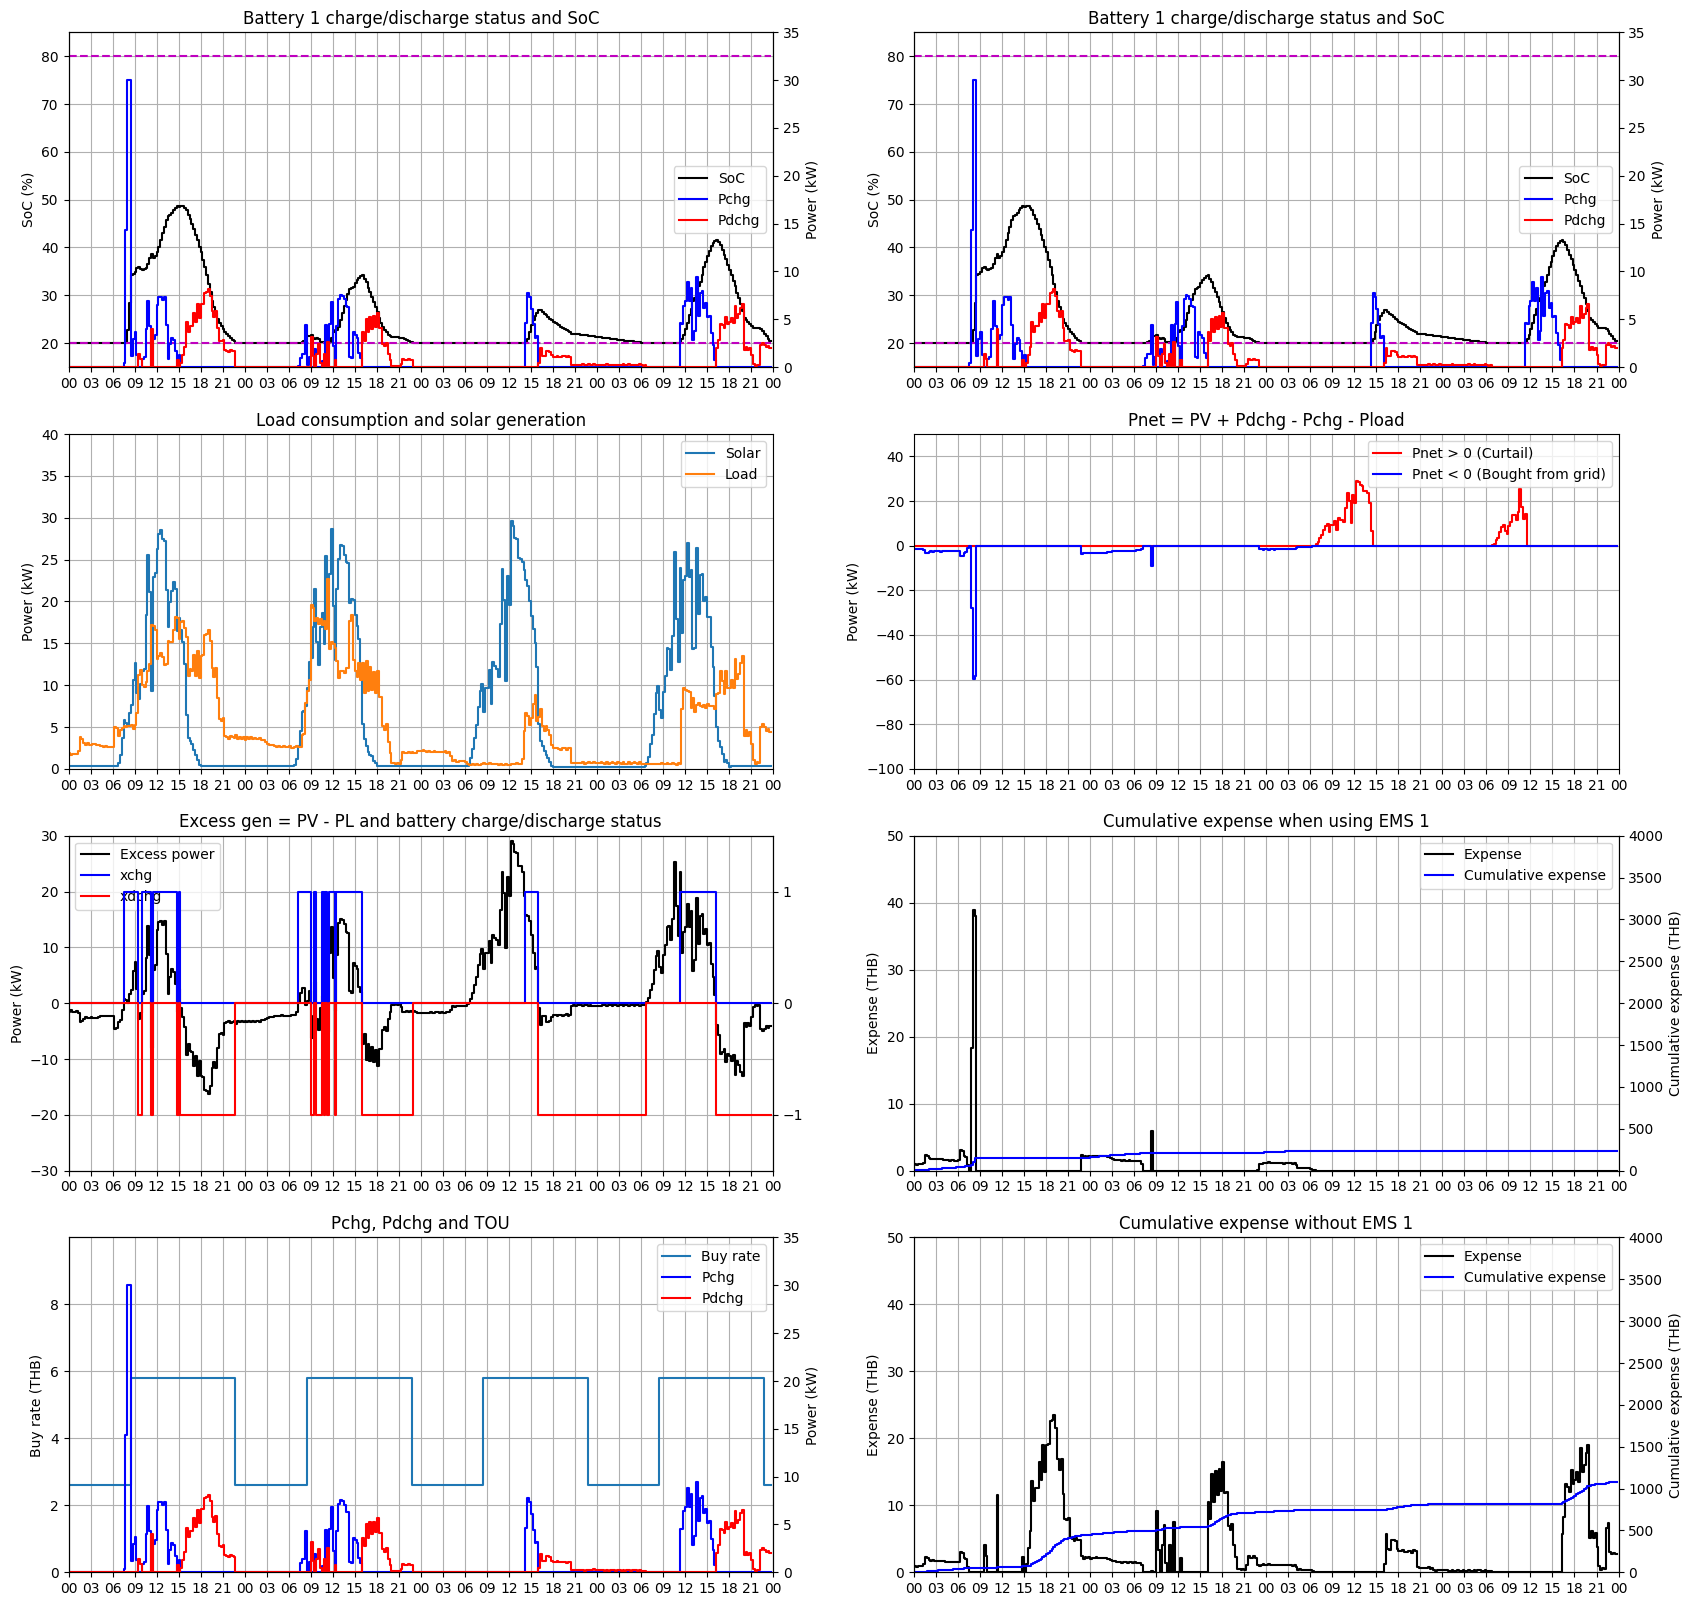

In [75]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
fig,ax = plt.subplots(4,2,figsize=(20,20))

excess_gen = PARAM['PV'] - PARAM['PL']
expense = sol['u1']
expense_noems = -np.minimum(0,excess_gen)*PARAM['Resolution']*PARAM['Buy_rate']
start_date = pd.to_datetime('2023-03-01')
end_date = start_date + datetime.timedelta(days=PARAM['Horizon'])
date = pd.date_range(start_date,end_date,freq=str(PARAM['Resolution']*60) + 'min')
date = date[:-1]
tick = pd.date_range(start_date,end_date,freq='3H')

#cell (0,0)
ax[0,0].step(date,sol['soc_1'],'-k',label='SoC')
ax[0,0].set_ylabel('SoC (%)')
ax[0,0].set_ylim([PARAM['battery']['min'][0] - 5,PARAM['battery']['max'][0] + 5])
ax[0,0].set_title('Battery 1 charge/discharge status and SoC')
ax[0,0].plot(date,PARAM['battery']['min'][0]*np.ones(384,),'--m')
ax[0,0].plot(date,PARAM['battery']['max'][0]*np.ones(384,),'--m')
ax00r = ax[0,0].twinx()
ax00r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
ax00r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
ax00r.set_ylabel('Power (kW)')
ax00r.set_ylim([0,PARAM['battery']['discharge_rate'][0]+5])
lines_left,labels_left =  ax[0,0].get_legend_handles_labels()
lines_right,labels_right =  ax00r.get_legend_handles_labels()
ax[0,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


#cell (0,1)
ax[0,1].step(date,sol['soc_2'],'-k',label='SoC')
ax[0,1].set_ylabel('SoC (%)')
ax[0,1].set_ylim([PARAM['battery']['min'][1] - 5,PARAM['battery']['max'][1] + 5])
ax[0,1].set_title('Battery 1 charge/discharge status and SoC')
ax[0,1].plot(date,PARAM['battery']['min'][1]*np.ones(384,),'--m')
ax[0,1].plot(date,PARAM['battery']['max'][1]*np.ones(384,),'--m')
ax01r = ax[0,1].twinx()
ax01r.step(date,sol['Pchg_2'],'-b',label = 'Pchg')
ax01r.step(date,sol['Pdchg_2'],'-r',label = 'Pdchg')
ax01r.set_ylabel('Power (kW)')
ax01r.set_ylim([0,PARAM['battery']['discharge_rate'][1]+5])
lines_left,labels_left =  ax[0,1].get_legend_handles_labels()
lines_right,labels_right =  ax01r.get_legend_handles_labels()
ax[0,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


# cell (1,0)
ax[1,0].step(date,PARAM['PV'],label='Solar')
ax[1,0].step(date,PARAM['PL'],label='Load')
ax[1,0].set_ylabel('Power (kW)')
ax[1,0].set_ylim([0,40])
ax[1,0].set_title('Load consumption and solar generation')
ax[1,0].legend()

# cell (1,1)
ax[1,1].step(date,np.maximum(0,sol['Pnet']),'-r',label='Pnet > 0 (Curtail)')
ax[1,1].step(date,np.minimum(0,sol['Pnet']),'-b',label='Pnet < 0 (Bought from grid)')
ax[1,1].set_ylabel('Power (kW)')
ax[1,1].set_ylim([-100,50])
ax[1,1].set_title('Pnet = PV + Pdchg - Pchg - Pload')
ax[1,1].legend()

#cell (2,0)
ax[2,0].step(date,excess_gen,'-k',label='Excess power')
ax[2,0].set_ylabel('Power (kW)')
ax[2,0].set_ylim([-30 ,30])
ax[2,0].set_title('Excess gen = PV - PL and battery charge/discharge status')
ax20r = ax[2,0].twinx()
ax20r.step(date,sol['xchg_1'],'-b',label = 'xchg')
ax20r.step(date,-sol['xdchg_1'],'-r',label = 'xdchg')
ax20r.set_ylim([-1.5,1.5])
ax20r.set_yticks([-1,0,1])
lines_left,labels_left =  ax[2,0].get_legend_handles_labels()
lines_right,labels_right =  ax20r.get_legend_handles_labels()
ax[2,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

#cell(2,1)
ax[2,1].step(date,expense,'-k',label='Expense')
ax[2,1].set_ylabel('Expense (THB)')
ax[2,1].set_ylim([0 ,50])
ax[2,1].set_yticks(range(0,60,10))
ax[2,1].set_title('Cumulative expense when using EMS 1')
ax21r = ax[2,1].twinx()
ax21r.step(date,expense.cumsum(),'-b',label = 'Cumulative expense')
ax21r.set_ylim([0,4000])
ax21r.set_ylabel('Cumulative expense (THB)')
lines_left,labels_left =  ax[2,1].get_legend_handles_labels()
lines_right,labels_right =  ax21r.get_legend_handles_labels()
ax[2,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


#cell(3,0)
ax[3,0].step(date,PARAM['Buy_rate'],label='Buy rate')
ax[3,0].set_ylabel('Buy rate (THB)')
ax[3,0].set_ylim([0 ,10])
ax[3,0].set_yticks(range(0,10,2))
ax[3,0].set_title('Pchg, Pdchg and TOU')
ax30r = ax[3,0].twinx()
ax30r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
ax30r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
ax30r.set_ylim([0,35])
ax30r.set_ylabel('Power (kW)')
lines_left,labels_left =  ax[3,0].get_legend_handles_labels()
lines_right,labels_right =  ax30r.get_legend_handles_labels()
ax[3,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

#cell(3,1)
ax[3,1].step(date,expense_noems,'-k',label='Expense')
ax[3,1].set_ylabel('Expense (THB)')
ax[3,1].set_ylim([0 ,50])
ax[3,1].set_yticks(range(0,60,10))
ax[3,1].set_title('Cumulative expense without EMS 1')
ax31r = ax[3,1].twinx()
ax31r.step(date,expense_noems.cumsum(),'-b',label = 'Cumulative expense')
ax31r.set_ylim([0,4000])
ax31r.set_ylabel('Cumulative expense (THB)')
lines_left,labels_left =  ax[3,1].get_legend_handles_labels()
lines_right,labels_right =  ax31r.get_legend_handles_labels()
ax[3,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)



for i in range(4) :
    for j in range(2) :
        ax[i,j].xaxis.set_major_formatter(DateFormatter('%H'))
        ax[i,j].set_xticks(tick)
        #ax[i,j].legend()
        ax[i,j].grid()
        ax[i,j].set_xlim([start_date,end_date])
        

In [74]:
def EMS_1_plot(PARAM,sol) :
        
    fig,ax = plt.subplots(4,2,figsize=(20,20))

    excess_gen = PARAM['PV'] - PARAM['PL']
    expense = sol['u1']
    expense_noems = -np.minimum(0,excess_gen)*PARAM['Resolution']*PARAM['Buy_rate']
    start_date = pd.to_datetime('2023-03-01')
    end_date = start_date + datetime.timedelta(days=PARAM['Horizon'])
    date = pd.date_range(start_date,end_date,freq=str(PARAM['Resolution']*60) + 'min')
    date = date[:-1]
    tick = pd.date_range(start_date,end_date,freq='3H')

    #cell (0,0)
    ax[0,0].step(date,sol['soc_1'],'-k',label='SoC')
    ax[0,0].set_ylabel('SoC (%)')
    ax[0,0].set_ylim([PARAM['battery']['min'][0] - 5,PARAM['battery']['max'][0] + 5])
    ax[0,0].set_title('Battery 1 charge/discharge status and SoC')
    ax[0,0].plot(date,PARAM['battery']['min'][0]*np.ones(384,),'--m')
    ax[0,0].plot(date,PARAM['battery']['max'][0]*np.ones(384,),'--m')
    ax00r = ax[0,0].twinx()
    ax00r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
    ax00r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
    ax00r.set_ylabel('Power (kW)')
    ax00r.set_ylim([0,PARAM['battery']['discharge_rate'][0]+5])
    lines_left,labels_left =  ax[0,0].get_legend_handles_labels()
    lines_right,labels_right =  ax00r.get_legend_handles_labels()
    ax[0,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    #cell (0,1)
    ax[0,1].step(date,sol['soc_2'],'-k',label='SoC')
    ax[0,1].set_ylabel('SoC (%)')
    ax[0,1].set_ylim([PARAM['battery']['min'][1] - 5,PARAM['battery']['max'][1] + 5])
    ax[0,1].set_title('Battery 1 charge/discharge status and SoC')
    ax[0,1].plot(date,PARAM['battery']['min'][1]*np.ones(384,),'--m')
    ax[0,1].plot(date,PARAM['battery']['max'][1]*np.ones(384,),'--m')
    ax01r = ax[0,1].twinx()
    ax01r.step(date,sol['Pchg_2'],'-b',label = 'Pchg')
    ax01r.step(date,sol['Pdchg_2'],'-r',label = 'Pdchg')
    ax01r.set_ylabel('Power (kW)')
    ax01r.set_ylim([0,PARAM['battery']['discharge_rate'][1]+5])
    lines_left,labels_left =  ax[0,1].get_legend_handles_labels()
    lines_right,labels_right =  ax01r.get_legend_handles_labels()
    ax[0,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    # cell (1,0)
    ax[1,0].step(date,PARAM['PV'],label='Solar')
    ax[1,0].step(date,PARAM['PL'],label='Load')
    ax[1,0].set_ylabel('Power (kW)')
    ax[1,0].set_ylim([0,40])
    ax[1,0].set_title('Load consumption and solar generation')
    ax[1,0].legend()

    # cell (1,1)
    ax[1,1].step(date,np.maximum(0,sol['Pnet']),'-r',label='Pnet > 0 (Curtail)')
    ax[1,1].step(date,np.minimum(0,sol['Pnet']),'-b',label='Pnet < 0 (Bought from grid)')
    ax[1,1].set_ylabel('Power (kW)')
    ax[1,1].set_ylim([-100,50])
    ax[1,1].set_title('Pnet = PV + Pdchg - Pchg - Pload')
    ax[1,1].legend()

    #cell (2,0)
    ax[2,0].step(date,excess_gen,'-k',label='Excess power')
    ax[2,0].set_ylabel('Power (kW)')
    ax[2,0].set_ylim([-30 ,30])
    ax[2,0].set_title('Excess gen = PV - PL and battery charge/discharge status')
    ax20r = ax[2,0].twinx()
    ax20r.step(date,sol['xchg_1'],'-b',label = 'xchg')
    ax20r.step(date,-sol['xdchg_1'],'-r',label = 'xdchg')
    ax20r.set_ylim([-1.5,1.5])
    ax20r.set_yticks([-1,0,1])
    lines_left,labels_left =  ax[2,0].get_legend_handles_labels()
    lines_right,labels_right =  ax20r.get_legend_handles_labels()
    ax[2,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

    #cell(2,1)
    ax[2,1].step(date,expense,'-k',label='Expense')
    ax[2,1].set_ylabel('Expense (THB)')
    ax[2,1].set_ylim([0 ,50])
    ax[2,1].set_yticks(range(0,60,10))
    ax[2,1].set_title('Cumulative expense when using EMS 1')
    ax21r = ax[2,1].twinx()
    ax21r.step(date,expense.cumsum(),'-b',label = 'Cumulative expense')
    ax21r.set_ylim([0,4000])
    ax21r.set_ylabel('Cumulative expense (THB)')
    lines_left,labels_left =  ax[2,1].get_legend_handles_labels()
    lines_right,labels_right =  ax21r.get_legend_handles_labels()
    ax[2,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    #cell(3,0)
    ax[3,0].step(date,PARAM['Buy_rate'],label='Buy rate')
    ax[3,0].set_ylabel('Buy rate (THB)')
    ax[3,0].set_ylim([0 ,10])
    ax[3,0].set_yticks(range(0,10,2))
    ax[3,0].set_title('Pchg, Pdchg and TOU')
    ax30r = ax[3,0].twinx()
    ax30r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
    ax30r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
    ax30r.set_ylim([0,35])
    ax30r.set_ylabel('Power (kW)')
    lines_left,labels_left =  ax[3,0].get_legend_handles_labels()
    lines_right,labels_right =  ax30r.get_legend_handles_labels()
    ax[3,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

    #cell(3,1)
    ax[3,1].step(date,expense_noems,'-k',label='Expense')
    ax[3,1].set_ylabel('Expense (THB)')
    ax[3,1].set_ylim([0 ,50])
    ax[3,1].set_yticks(range(0,60,10))
    ax[3,1].set_title('Cumulative expense without EMS 1')
    ax31r = ax[3,1].twinx()
    ax31r.step(date,expense_noems.cumsum(),'-b',label = 'Cumulative expense')
    ax31r.set_ylim([0,4000])
    ax31r.set_ylabel('Cumulative expense (THB)')
    lines_left,labels_left =  ax[3,1].get_legend_handles_labels()
    lines_right,labels_right =  ax31r.get_legend_handles_labels()
    ax[3,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)



    for i in range(4) :
        for j in range(2) :
            ax[i,j].xaxis.set_major_formatter(DateFormatter('%H'))
            ax[i,j].set_xticks(tick)
            #ax[i,j].legend()
            ax[i,j].grid()
            ax[i,j].set_xlim([start_date,end_date])
    return        

In [ ]:
def EMS_1_plot(PARAM,sol) :
        
    fig,ax = plt.subplots(4,2,figsize=(20,20))

    excess_gen = PARAM['PV'] - PARAM['PL']
    expense = sol['u1']
    expense_noems = -np.minimum(0,excess_gen)*PARAM['Resolution']*PARAM['Buy_rate']
    start_date = pd.to_datetime('2023-03-01')
    end_date = start_date + datetime.timedelta(days=PARAM['Horizon'])
    date = pd.date_range(start_date,end_date,freq=str(PARAM['Resolution']*60) + 'min')
    date = date[:-1]
    tick = pd.date_range(start_date,end_date,freq='3H')

    #cell (0,0)
    ax[0,0].step(date,sol['soc_1'],'-k',label='SoC')
    ax[0,0].set_ylabel('SoC (%)')
    ax[0,0].set_ylim([PARAM['battery']['min'][0] - 5,PARAM['battery']['max'][0] + 5])
    ax[0,0].set_title('Battery 1 charge/discharge status and SoC')
    ax[0,0].plot(date,PARAM['battery']['min'][0]*np.ones(384,),'--m')
    ax[0,0].plot(date,PARAM['battery']['max'][0]*np.ones(384,),'--m')
    ax00r = ax[0,0].twinx()
    ax00r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
    ax00r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
    ax00r.set_ylabel('Power (kW)')
    ax00r.set_ylim([0,PARAM['battery']['discharge_rate'][0]+5])
    lines_left,labels_left =  ax[0,0].get_legend_handles_labels()
    lines_right,labels_right =  ax00r.get_legend_handles_labels()
    ax[0,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    #cell (0,1)
    ax[0,1].step(date,sol['soc_2'],'-k',label='SoC')
    ax[0,1].set_ylabel('SoC (%)')
    ax[0,1].set_ylim([PARAM['battery']['min'][1] - 5,PARAM['battery']['max'][1] + 5])
    ax[0,1].set_title('Battery 2 charge/discharge status and SoC')
    ax[0,1].plot(date,PARAM['battery']['min'][1]*np.ones(384,),'--m')
    ax[0,1].plot(date,PARAM['battery']['max'][1]*np.ones(384,),'--m')
    ax01r = ax[0,1].twinx()
    ax01r.step(date,sol['Pchg_2'],'-b',label = 'Pchg')
    ax01r.step(date,sol['Pdchg_2'],'-r',label = 'Pdchg')
    ax01r.set_ylabel('Power (kW)')
    ax01r.set_ylim([0,PARAM['battery']['discharge_rate'][1]+5])
    lines_left,labels_left =  ax[0,1].get_legend_handles_labels()
    lines_right,labels_right =  ax01r.get_legend_handles_labels()
    ax[0,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    # cell (1,0)
    ax[1,0].step(date,PARAM['PV'],label='Solar')
    ax[1,0].step(date,PARAM['PL'],label='Load')
    ax[1,0].set_ylabel('Power (kW)')
    ax[1,0].set_ylim([0,40])
    ax[1,0].set_title('Load consumption and solar generation')
    ax[1,0].legend()

    # cell (1,1)
    ax[1,1].step(date,np.maximum(0,sol['Pnet']),'-r',label='Pnet > 0 (Curtail)')
    ax[1,1].step(date,np.minimum(0,sol['Pnet']),'-b',label='Pnet < 0 (Bought from grid)')
    ax[1,1].set_ylabel('Power (kW)')
    ax[1,1].set_ylim([-100,50])
    ax[1,1].set_title('Pnet = PV + Pdchg - Pchg - Pload')
    ax[1,1].legend()

    #cell (2,0)
    ax[2,0].step(date,excess_gen,'-k',label='Excess power')
    ax[2,0].set_ylabel('Power (kW)')
    ax[2,0].set_ylim([-30 ,30])
    ax[2,0].set_title('Excess gen = PV - PL and battery charge/discharge status')
    ax20r = ax[2,0].twinx()
    ax20r.step(date,sol['xchg_1'],'-b',label = 'xchg')
    ax20r.step(date,-sol['xdchg_1'],'-r',label = 'xdchg')
    ax20r.set_ylim([-1.5,1.5])
    ax20r.set_yticks([-1,0,1])
    lines_left,labels_left =  ax[2,0].get_legend_handles_labels()
    lines_right,labels_right =  ax20r.get_legend_handles_labels()
    ax[2,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

    #cell(2,1)
    ax[2,1].step(date,expense,'-k',label='Expense')
    ax[2,1].set_ylabel('Expense (THB)')
    ax[2,1].set_ylim([0 ,50])
    ax[2,1].set_yticks(range(0,60,10))
    ax[2,1].set_title('Cumulative expense when using EMS 1')
    ax21r = ax[2,1].twinx()
    ax21r.step(date,expense.cumsum(),'-b',label = 'Cumulative expense')
    ax21r.set_ylim([0,4000])
    ax21r.set_ylabel('Cumulative expense (THB)')
    lines_left,labels_left =  ax[2,1].get_legend_handles_labels()
    lines_right,labels_right =  ax21r.get_legend_handles_labels()
    ax[2,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


    #cell(3,0)
    ax[3,0].step(date,PARAM['Buy_rate'],label='Buy rate')
    ax[3,0].set_ylabel('Buy rate (THB)')
    ax[3,0].set_ylim([0 ,10])
    ax[3,0].set_yticks(range(0,10,2))
    ax[3,0].set_title('Pchg, Pdchg and TOU')
    ax30r = ax[3,0].twinx()
    ax30r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
    ax30r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
    ax30r.set_ylim([0,35])
    ax30r.set_ylabel('Power (kW)')
    lines_left,labels_left =  ax[3,0].get_legend_handles_labels()
    lines_right,labels_right =  ax30r.get_legend_handles_labels()
    ax[3,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

    #cell(3,1)
    ax[3,1].step(date,expense_noems,'-k',label='Expense')
    ax[3,1].set_ylabel('Expense (THB)')
    ax[3,1].set_ylim([0 ,50])
    ax[3,1].set_yticks(range(0,60,10))
    ax[3,1].set_title('Cumulative expense without EMS 1')
    ax31r = ax[3,1].twinx()
    ax31r.step(date,expense_noems.cumsum(),'-b',label = 'Cumulative expense')
    ax31r.set_ylim([0,4000])
    ax31r.set_ylabel('Cumulative expense (THB)')
    lines_left,labels_left =  ax[3,1].get_legend_handles_labels()
    lines_right,labels_right =  ax31r.get_legend_handles_labels()
    ax[3,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)



    for i in range(4) :
        for j in range(2) :
            ax[i,j].xaxis.set_major_formatter(DateFormatter('%H'))
            ax[i,j].set_xticks(tick)
            #ax[i,j].legend()
            ax[i,j].grid()
            ax[i,j].set_xlim([start_date,end_date])
    return        

In [76]:
def GetExpense(Pnet,Buy_rate,Sell_rate,Resolution) :
    # Pnet vector same length as Buy/Sell_rate
    # Resolution (Hr)
    
    expense = np.minimum(0,Pnet)*Buy_rate*Resolution
    revenue = np.maximum(0,Pnet)*Sell_rate*Resolution
    profit = expense + revenue
    return profit,expense,revenue 

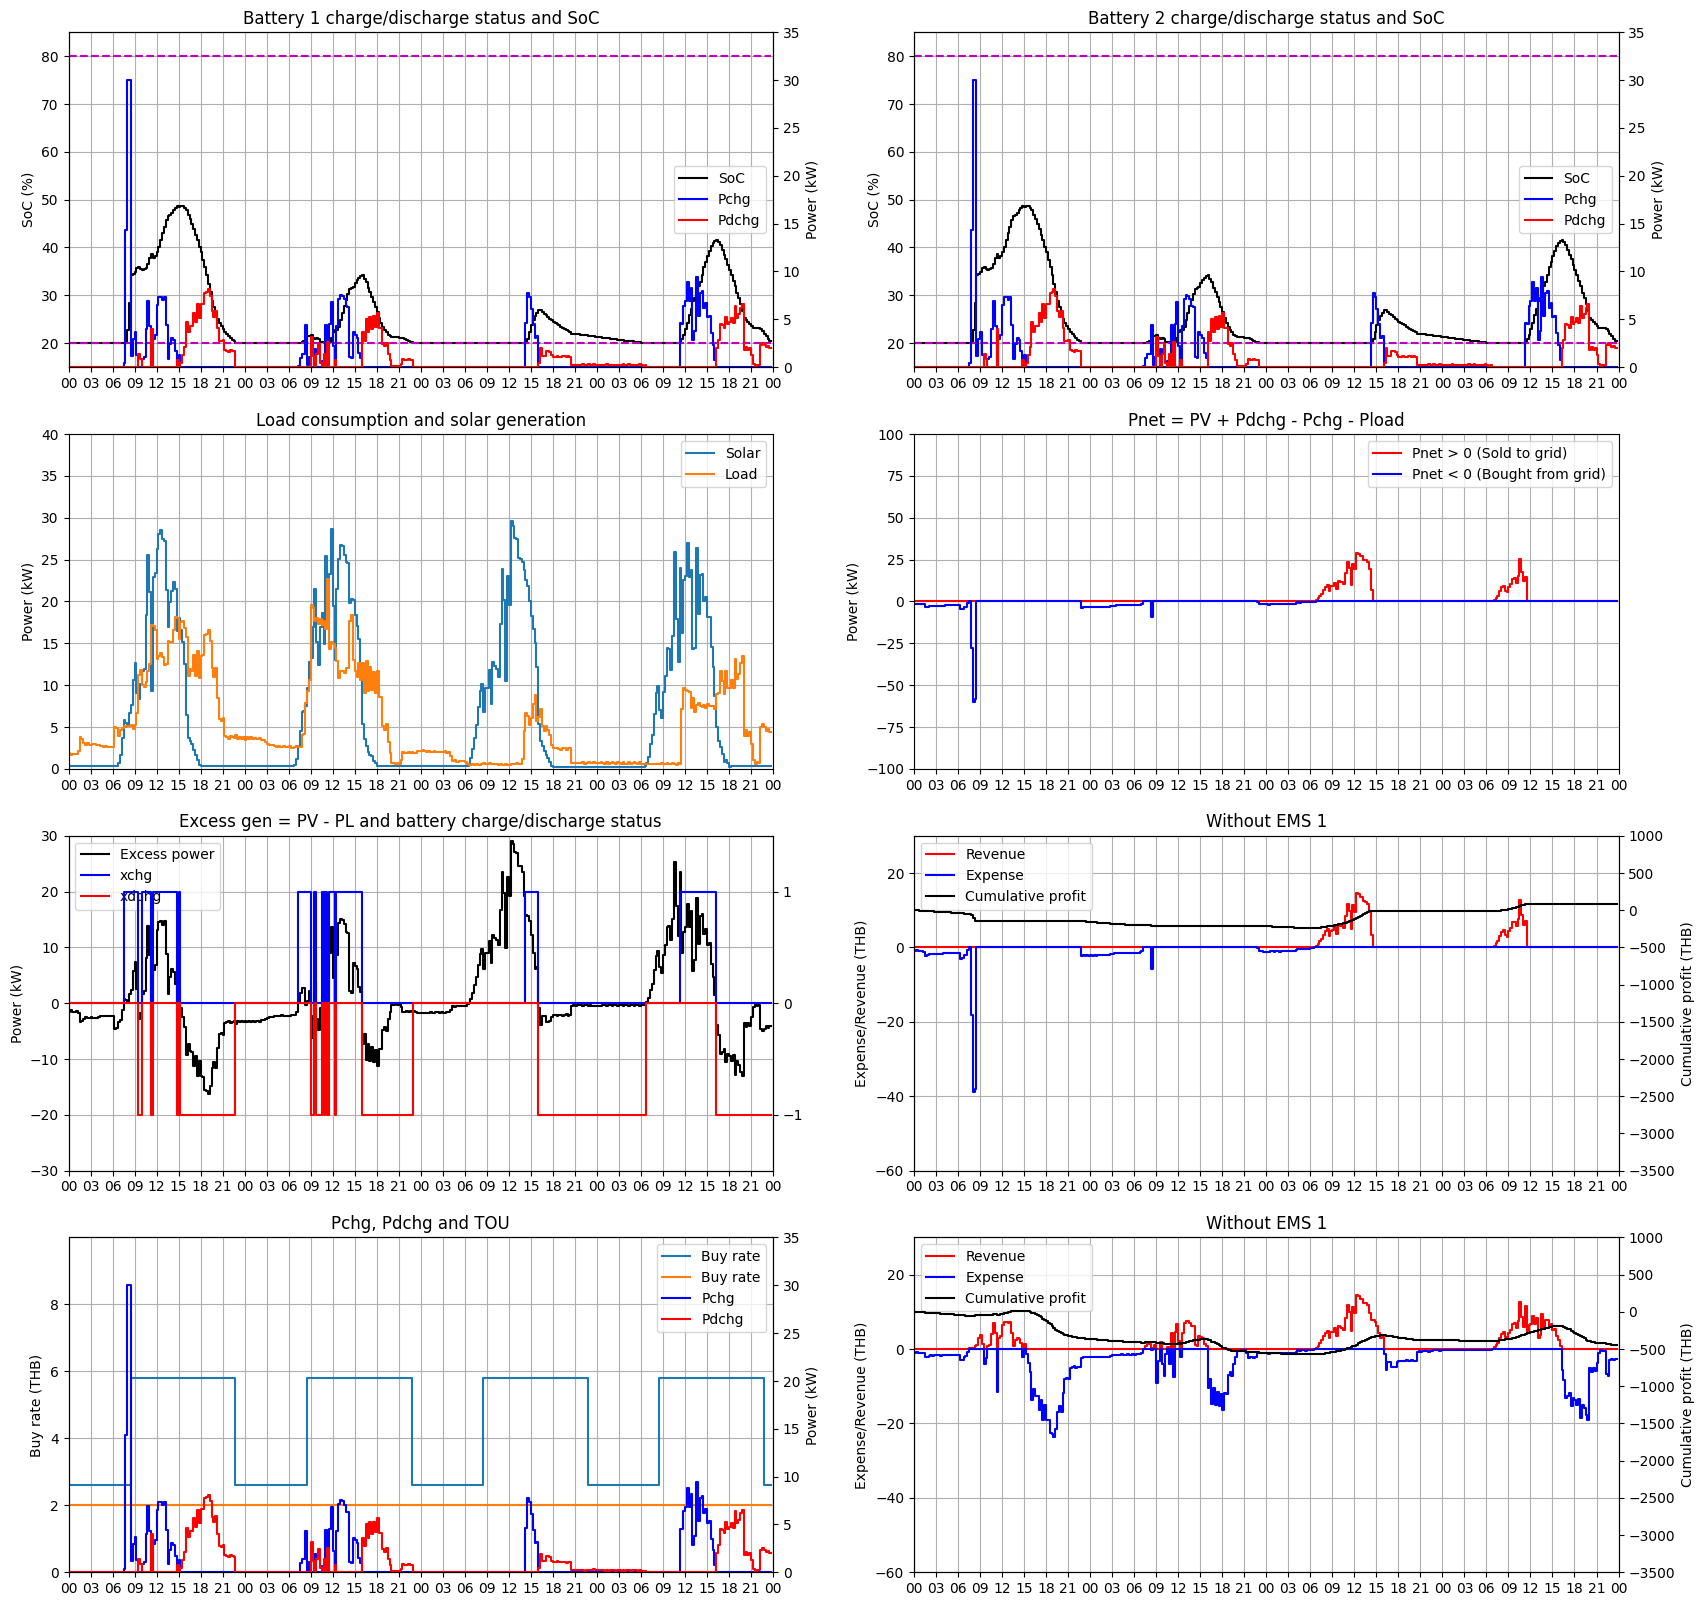

In [80]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
fig,ax = plt.subplots(4,2,figsize=(20,20))

excess_gen = PARAM['PV'] - PARAM['PL']
profit,expense,revenue = GetExpense(sol['Pnet'],PARAM['Buy_rate'],PARAM['Sell_rate'],PARAM['Resolution'])
profit_noems,expense_noems,revenue_noems  = GetExpense(excess_gen,PARAM['Buy_rate'],PARAM['Sell_rate'],PARAM['Resolution'])
start_date = pd.to_datetime('2023-03-01')
end_date = start_date + datetime.timedelta(days=PARAM['Horizon'])
date = pd.date_range(start_date,end_date,freq=str(PARAM['Resolution']*60) + 'min')
date = date[:-1]
tick = pd.date_range(start_date,end_date,freq='3H')

#cell (0,0)
ax[0,0].step(date,sol['soc_1'],'-k',label='SoC')
ax[0,0].set_ylabel('SoC (%)')
ax[0,0].set_ylim([PARAM['battery']['min'][0] - 5,PARAM['battery']['max'][0] + 5])
ax[0,0].set_title('Battery 1 charge/discharge status and SoC')
ax[0,0].plot(date,PARAM['battery']['min'][0]*np.ones(384,),'--m')
ax[0,0].plot(date,PARAM['battery']['max'][0]*np.ones(384,),'--m')
ax00r = ax[0,0].twinx()
ax00r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
ax00r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
ax00r.set_ylabel('Power (kW)')
ax00r.set_ylim([0,PARAM['battery']['discharge_rate'][0]+5])
lines_left,labels_left =  ax[0,0].get_legend_handles_labels()
lines_right,labels_right =  ax00r.get_legend_handles_labels()
ax[0,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


#cell (0,1)
ax[0,1].step(date,sol['soc_2'],'-k',label='SoC')
ax[0,1].set_ylabel('SoC (%)')
ax[0,1].set_ylim([PARAM['battery']['min'][1] - 5,PARAM['battery']['max'][1] + 5])
ax[0,1].set_title('Battery 2 charge/discharge status and SoC')
ax[0,1].plot(date,PARAM['battery']['min'][1]*np.ones(384,),'--m')
ax[0,1].plot(date,PARAM['battery']['max'][1]*np.ones(384,),'--m')
ax01r = ax[0,1].twinx()
ax01r.step(date,sol['Pchg_2'],'-b',label = 'Pchg')
ax01r.step(date,sol['Pdchg_2'],'-r',label = 'Pdchg')
ax01r.set_ylabel('Power (kW)')
ax01r.set_ylim([0,PARAM['battery']['discharge_rate'][1]+5])
lines_left,labels_left =  ax[0,1].get_legend_handles_labels()
lines_right,labels_right =  ax01r.get_legend_handles_labels()
ax[0,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


# cell (1,0)
ax[1,0].step(date,PARAM['PV'],label='Solar')
ax[1,0].step(date,PARAM['PL'],label='Load')
ax[1,0].set_ylabel('Power (kW)')
ax[1,0].set_ylim([0,40])
ax[1,0].set_title('Load consumption and solar generation')
ax[1,0].legend()

# cell (1,1)
ax[1,1].step(date,np.maximum(0,sol['Pnet']),'-r',label='Pnet > 0 (Sold to grid)')
ax[1,1].step(date,np.minimum(0,sol['Pnet']),'-b',label='Pnet < 0 (Bought from grid)')
ax[1,1].set_ylabel('Power (kW)')
ax[1,1].set_ylim([-100,100])
ax[1,1].set_title('Pnet = PV + Pdchg - Pchg - Pload')
ax[1,1].legend()

#cell (2,0)
ax[2,0].step(date,excess_gen,'-k',label='Excess power')
ax[2,0].set_ylabel('Power (kW)')
ax[2,0].set_ylim([-30 ,30])
ax[2,0].set_title('Excess gen = PV - PL and battery charge/discharge status')
ax20r = ax[2,0].twinx()
ax20r.step(date,sol['xchg_1'],'-b',label = 'xchg')
ax20r.step(date,-sol['xdchg_1'],'-r',label = 'xdchg')
ax20r.set_ylim([-1.5,1.5])
ax20r.set_yticks([-1,0,1])
lines_left,labels_left =  ax[2,0].get_legend_handles_labels()
lines_right,labels_right =  ax20r.get_legend_handles_labels()
ax[2,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

#cell(2,1)
ax[2,1].step(date,revenue,'-r',label='Revenue')
ax[2,1].step(date,expense,'-b',label='Expense')
ax[2,1].set_ylabel('Expense/Revenue (THB)')
ax[2,1].set_ylim([-60 ,30])
ax[2,1].set_yticks(range(-60,40,20))
ax[2,1].set_title('Without EMS 1')
ax21r = ax[2,1].twinx()
ax21r.step(date,profit.cumsum(),'-k',label = 'Cumulative profit')
ax21r.set_ylim([-3500,1000])
ax21r.set_ylabel('Cumulative profit (THB)')
lines_left,labels_left =  ax[2,1].get_legend_handles_labels()
lines_right,labels_right =  ax31r.get_legend_handles_labels()
ax[2,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)


#cell(3,0)
ax[3,0].step(date,PARAM['Buy_rate'],label='Buy rate')
ax[3,0].step(date,PARAM['Sell_rate'],label='Buy rate')
ax[3,0].set_ylabel('Buy rate (THB)')
ax[3,0].set_ylim([0 ,10])
ax[3,0].set_yticks(range(0,10,2))
ax[3,0].set_title('Pchg, Pdchg and TOU')
ax30r = ax[3,0].twinx()
ax30r.step(date,sol['Pchg_1'],'-b',label = 'Pchg')
ax30r.step(date,sol['Pdchg_1'],'-r',label = 'Pdchg')
ax30r.set_ylim([0,35])
ax30r.set_ylabel('Power (kW)')
lines_left,labels_left =  ax[3,0].get_legend_handles_labels()
lines_right,labels_right =  ax30r.get_legend_handles_labels()
ax[3,0].legend(lines_left + lines_right,labels_left + labels_right,loc=0)

#cell(3,1)
ax[3,1].step(date,revenue_noems,'-r',label='Revenue')
ax[3,1].step(date,expense_noems,'-b',label='Expense')
ax[3,1].set_ylabel('Expense/Revenue (THB)')
ax[3,1].set_ylim([-60 ,30])
ax[3,1].set_yticks(range(-60,40,20))
ax[3,1].set_title('Without EMS 1')
ax31r = ax[3,1].twinx()
ax31r.step(date,profit_noems.cumsum(),'-k',label = 'Cumulative profit')
ax31r.set_ylim([-3500,1000])
ax31r.set_ylabel('Cumulative profit (THB)')
lines_left,labels_left =  ax[3,1].get_legend_handles_labels()
lines_right,labels_right =  ax31r.get_legend_handles_labels()
ax[3,1].legend(lines_left + lines_right,labels_left + labels_right,loc=0)



for i in range(4) :
    for j in range(2) :
        ax[i,j].xaxis.set_major_formatter(DateFormatter('%H'))
        ax[i,j].set_xticks(tick)
        #ax[i,j].legend()
        ax[i,j].grid()
        ax[i,j].set_xlim([start_date,end_date])
        